In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras import backend
import pickle

In [2]:
def plot_confusion_matrix(test_labels, predicted_labels, save_path=None, encoder=None):
    if encoder:
      test_labels = encoder.inverse_transform(test_labels)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=[10, 10], dpi=100)
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    classes = unique_labels(test_labels, predicted_labels)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.3f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [3]:
path = 'DL_preprocessed/'

In [4]:
df_train = pd.read_csv(path+'train.csv', index_col=0)

In [5]:
df_train.head()

,timestamp,category,state,customer,product,scaled_price,rating
700,2017-08-24 11:31:28,49,22,44869,23910,-0.411884,0
5075,2017-08-05 14:52:23,49,22,2937,1466,-0.533291,1
23537,2017-09-30 14:48:37,49,22,42130,27460,-0.342433,1
37160,2017-08-28 20:15:12,49,22,18783,27104,-0.429061,0
39136,2018-06-06 17:30:59,49,22,81457,21065,-0.322181,1


In [6]:
df_test = pd.read_csv(path+'test.csv', index_col=0)

In [7]:
df_test.head()

,timestamp,category,state,customer,product,scaled_price,rating
11738739,2018-09-03 09:06:57,51,22,93555,23364,0.108736,0
2948445,2018-08-28 21:56:12,39,16,6024,2840,-0.554498,1
592044,2018-08-28 19:32:05,49,22,92236,14190,-0.394972,1
606768,2018-08-28 10:57:13,49,22,19405,6370,-0.500952,0
1361404,2018-08-27 22:59:03,65,22,24225,19324,-0.437332,1


In [8]:
value_counts = pickle.load(open(path+'unique_counts.sav', 'rb'))

# Model definition

In [9]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [10]:
def RecommenderNet(value_counts: list, n_factors, include_price = False, output_nodes = 1):
    inputs = []
    emb_layers = []
    for ii, count in enumerate(value_counts):
        inputs.append(Input(shape=(1,)))
        emb_layers.append(EmbeddingLayer(count+1, n_factors)(inputs[ii]))
    
    price_input = []
    if include_price:
        price_input.append(Input(shape=(1,)))

    x = Concatenate()(emb_layers)
#     x = Concatenate()(emb_layers)
    x = Dropout(0.3)(x)
    
    if include_price:
        x = Concatenate(x, price_input)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(output_nodes, kernel_initializer='he_normal')(x)
    if output_nodes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)
    model = Model(inputs=inputs+price_input, outputs=x)
    opt = Adam(lr=0.001)
    if output_nodes == 1:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    else:
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Basic training

In [11]:
def df_to_list_of_lists(df):
    result = []
    for column in df.keys():
        result.append(df.loc[:,column].values)
    return result

In [12]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

X_train = [df_train.loc[:,'customer'].values, df_train.loc[:,'product'].values] 
#X_train = df_to_list_of_lists(df_train.drop(columns=['rating', 'timestamp', 'scaled_price']))
y_train = df_train.rating

X_test = [df_test.loc[:,'customer'].values, df_test.loc[:,'product'].values]
#X_test= df_to_list_of_lists(df_test.drop(columns=['rating', 'timestamp', 'scaled_price']))
y_test = df_test.rating

In [13]:
X_train

[array([78460, 26022, 62396, ..., 52211, 49456, 14259], dtype=int64),
 array([   76, 17543,  7132, ...,  6932, 10337, 25307], dtype=int64)]

In [14]:
n_factors=5

In [15]:
value_counts

{'category': 71, 'state': 23, 'customer': 93885, 'product': 32267}

In [16]:
#model = RecommenderNet(value_counts.values(), n_factors)
model = RecommenderNet([value_counts['customer'], value_counts['product']], n_factors)

history = model.fit(x=X_train, y=y_train, batch_size=51200, epochs=4000,
                    verbose=0, validation_data=(X_test, y_test))

C:\Users\mwasi\anaconda3\envs\Data\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


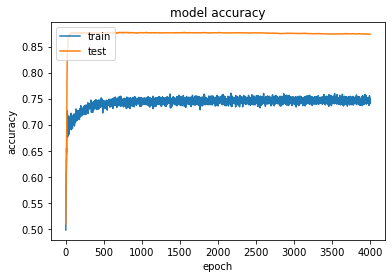

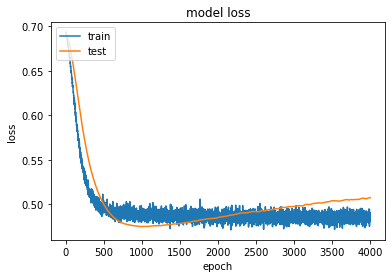

In [17]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#model = RecommenderNet(value_counts.values(), n_factors)
model = RecommenderNet([value_counts['customer'], value_counts['product']], n_factors)

history = model.fit(x=X_train, y=y_train, batch_size=51200, epochs=1200,
                    verbose=0, validation_data=(X_test, y_test))

In [20]:
y_pred = model.predict(X_test)#.astype(int).flatten()
y_pred = np.rint(y_pred)

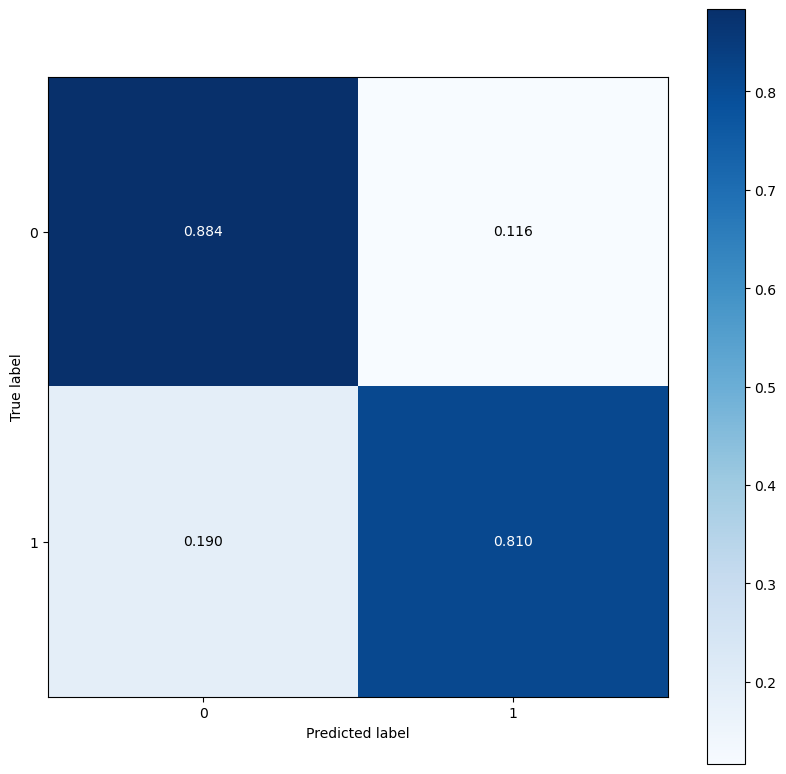

In [21]:
plot_confusion_matrix(y_test, y_pred, save_path='conf_matrix_binary.png')

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2784
           1       0.88      0.81      0.84      2880

    accuracy                           0.85      5664
   macro avg       0.85      0.85      0.85      5664
weighted avg       0.85      0.85      0.85      5664



In [23]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [24]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

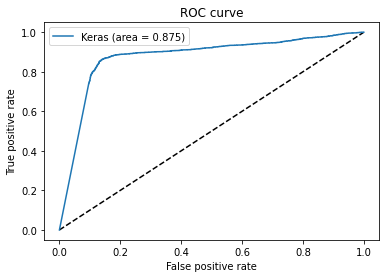

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()